# Imports

In [1]:
import sys
 
# setting path
sys.path.append('..')

In [2]:
from model_builder import ModelBuilder

# Model

In [3]:
model_builder = ModelBuilder()

# Create Dataset

In [4]:
label=['Response_Variable_Brazil_Atlantic_Forest_0forest_1deforested']
feature_names=['aspect', 'brazil_agriculture', 'brazil_pasture', 'brazil_protected_areas', 'brazil_roads',
                                            'brazil_surrounding_forest', 'elevation', 'forest_age', 'hillshade', 'population_density','slope', 
                                            'south_america_rivers']
gcp_bucket= 'eartshot-science-team'
gcp_folder_name= 'deforestation_risk'
samples_folder_name= f'Brazil_samples_csv_scale30_2000numPixels'
name_csv_samples_merged_file = 'Brazil_samples_csv_scale30_2000numPixels_val_test_set_10km_buffer.csv'

In [5]:
model_builder.create_dataset(response_variable=label, 
                             feature_names=feature_names, 
                             gcp_bucket=gcp_bucket, 
                             gcp_folder_name=gcp_folder_name, 
                             samples_folder_name= samples_folder_name, 
                             name_csv_samples_merged_file = name_csv_samples_merged_file, 
                             use_test_val_buffered_sets = True)

Reading sample csv file: gs://eartshot-science-team/deforestation_risk/Brazil_samples_csv_scale30_2000numPixels/Brazil_samples_csv_scale30_2000numPixels_val_test_set_10km_buffer.csv...
We have 63370 samples
Training samples: 54088
Test samples: 2622
Validation samples: 5411


In [6]:
model_builder.X_train.shape

(54088, 12)

In [7]:
model_builder.feature_names

['aspect',
 'brazil_agriculture',
 'brazil_pasture',
 'brazil_protected_areas',
 'brazil_roads',
 'brazil_surrounding_forest',
 'elevation',
 'forest_age',
 'hillshade',
 'population_density',
 'slope',
 'south_america_rivers']

In [8]:
model_builder.response_variable

['Response_Variable_Brazil_Atlantic_Forest_0forest_1deforested']

# Hyperparameters tuning

Finding best hyperparameters with GridSearch

In [9]:
best_params = model_builder.grid_search(n_estimators=[100, 200, 500], 
                                        max_features=['sqrt', 'log2'], 
                                        max_depth=[4,5,6,7,8], 
                                        criterion=['squared_error', 'absolute_error'], 
                                        random_state=42)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
{'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}


In [10]:
best_params

{'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': 'sqrt',
 'n_estimators': 100}

# Training

In [10]:
model_builder.initialize_model(nb_trees=100, max_depth=2, random_state=42, max_features=1.0, n_cores=-1, 
                                 oob_score=True, bootstrap=True, criterion='squared_error'

/Users/margauxmforstyhe/Desktop/workspace/Earthshot Labs/workspace/Science/model_utilities/model_utilities/tests/../model_builder.py:171: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model = self.model.fit(self.X_train, self.y_train)
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


In [ ]:
model_builder.model

In [ ]:
model_builder.train()

# Evaluation


Evaluation...



Mean Absolute Error (MAE): 0.11429919420881578
Mean Squared Error (MSE): 0.05367394965041569
Root Mean Squared Error (RMSE): 0.23167638992874456
OOB prediction of accuracy is: 1.4229025503510684%

R2: 0.003173239016301399


/usr/local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


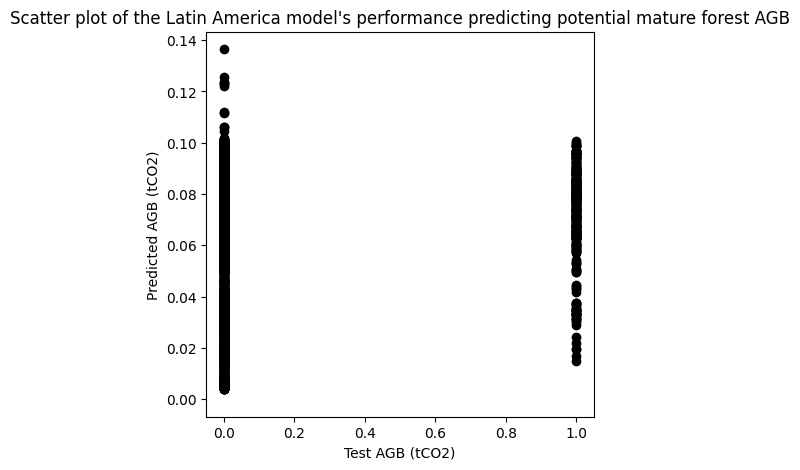

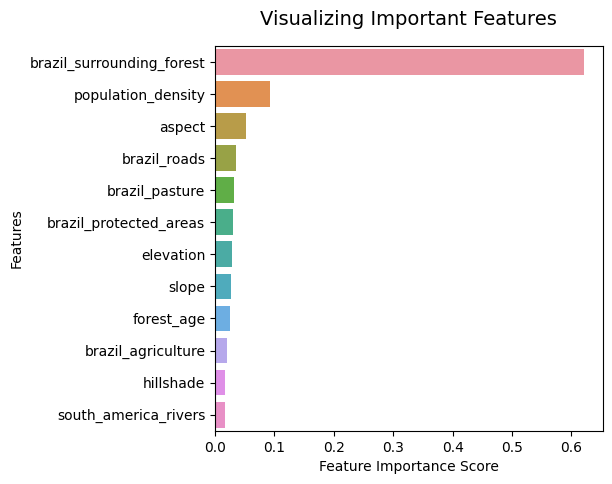

In [11]:
# On validation set
mae_val, mse_val, rmse_val, oob_score_val, r2_val, feature_imp_val = model_builder.evaluate(X_test=model_builder.X_val,
                                                                    y_test=model_builder.y_val,
                                                                    save_figures=True, saving_base_output_name='testing_val_set')


Evaluation...



Mean Absolute Error (MAE): 0.13951448942403452
Mean Squared Error (MSE): 0.07826861484899961
Root Mean Squared Error (RMSE): 0.27976528528214434
OOB prediction of accuracy is: 1.4229025503510684%

R2: -0.0017418680886411853


/usr/local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


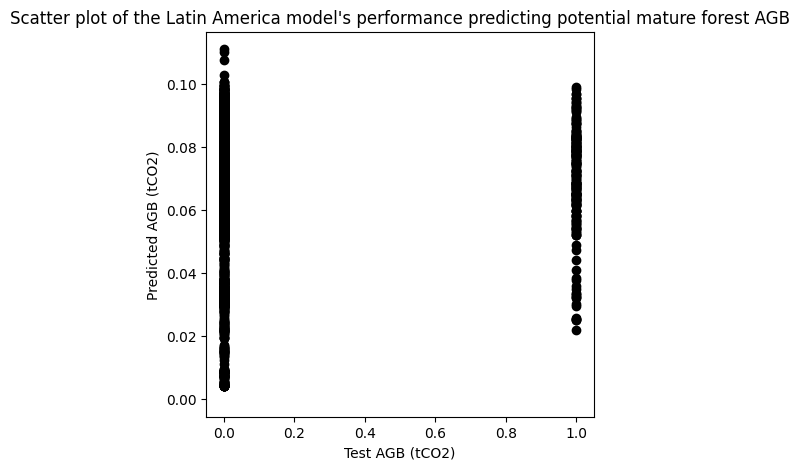

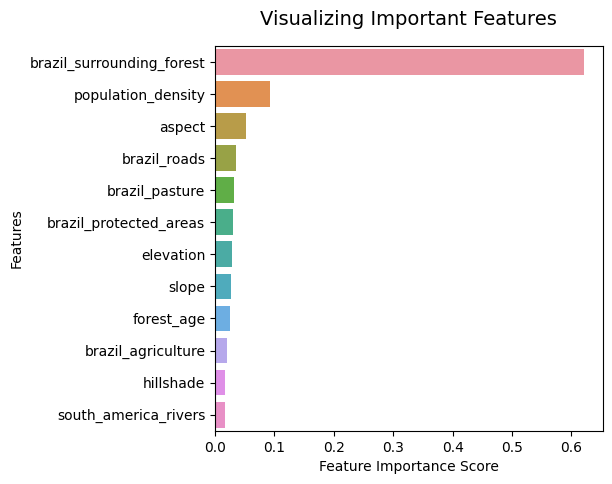

In [12]:
# On test set
mae_test, mse_test, rmse_test, oob_score_test, r2_test, feature_imp_test = model_builder.evaluate(X_test=model_builder.X_test,
                                                                    y_test=model_builder.y_test,
                                                                    save_figures=True, saving_base_output_name='testing_test_set')

# Inference on tiles

In [ ]:
model_builder.inference(mask_band='forest_age', 
                        tiles_folder_name='Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster', 
                        tiles_in_GCP=False,   # Running locally
                        RF_output_folder_temp='TEST_RF_outputs_temp',
                        path_to_tiles_local='/Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster'
                       )


There are 58 inference tiles

Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_52.tif
Image opened
tile shape: (7422, 6857, 12)
Reshaped from (7422, 6857, 12) to (50892654, 12)
(50892654, 12)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  1.6min finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 6857)
[ 0 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 86 91 93]
(7422, 6857)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-17-10_29_49_0.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_46.tif
Image opened
tile shape: (2665, 3127, 12)
Reshaped from (2665, 3127, 12) to (8333455, 12)
(8333455, 12)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    4.0s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (2665, 3127)
[ 0 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37
 38 39 40 41 42 43 44 45 46 47 48 49]
(2665, 3127)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-17-10_29_58_1.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_8.tif
Image opened
tile shape: (7422, 7422, 12)
Reshaped from (7422, 7422, 12) to (55086084, 12)
(55086084, 12)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   21.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  1.6min finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7422)
[ 0 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40
 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66]
(7422, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-17-10_33_05_2.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_9.tif
Image opened
tile shape: (7422, 7422, 12)
Reshaped from (7422, 7422, 12) to (55086084, 12)
(55086084, 12)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   29.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  1.5min finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7422)
[ 0 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36
 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68]
(7422, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-17-10_36_23_3.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_47.tif
Image opened
tile shape: (7422, 7422, 12)
Reshaped from (7422, 7422, 12) to (55086084, 12)
(55086084, 12)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   32.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  1.6min finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7422)
[ 0  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 72 73 78 81]
(7422, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-17-10_40_03_4.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_53.tif
Image opened
tile shape: (7422, 7423, 12)
Reshaped from (7422, 7423, 12) to (55093506, 12)
(55093506, 12)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   34.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  1.7min finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7422, 7423)
[ 0 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81]
(7422, 7423)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-17-10_44_01_5.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_45.tif
Image opened
tile shape: (4900, 7422, 12)
Reshaped from (4900, 7422, 12) to (36367800, 12)
(36367800, 12)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   14.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   27.0s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (4900, 7422)
[ 0  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
 32 33 34 35 36 37 38 39 40 41 42 43 44 46 47 48]
(4900, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-17-10_45_40_6.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_51.tif
Image opened
tile shape: (4242, 4779, 12)
Reshaped from (4242, 4779, 12) to (20272518, 12)
(20272518, 12)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    4.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   10.7s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (4242, 4779)
[ 0 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41
 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 65]
(4242, 4779)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-17-10_46_34_7.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_50.tif
Image opened
tile shape: (1534, 511, 12)
Reshaped from (1534, 511, 12) to (783874, 12)
(783874, 12)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.4s finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (1534, 511)
[0]
(1534, 511)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-17-10_46_35_8.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_44.tif
Image opened
tile shape: (7423, 7422, 12)
Reshaped from (7423, 7422, 12) to (55093506, 12)
(55093506, 12)


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   30.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  1.6min finished


Class prediction was successful without slicing!
No slicing was necessary!
Reshaped back to (7423, 7422)
[  0   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25
  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  93  97  99 101]
(7423, 7422)
Image saved to: TEST_RF_outputs_temp/RF_output_2022-11-17-10_49_44_9.tif




Starting image: /Users/margauxmforstyhe/Desktop/Brazil_Deforestation_Risk_inference_2degrees_grid_scale30_with_spawn_as_base_raster/inference_tiles_scale30_40.tif
Image opened
